# Vegetation detection with autoencoder network

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [12]:
import os
import logging
import sys
sys.path.append("../common/")

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [9]:
from data_utils import TRAIN_IMAGE_IDS, LABELS, TRAIN_DATA
from image_utils import get_image_data, get_image_tile_data, normalize
from visu_utils import display_img_1b, display_labels

In [5]:
import cv2

### Input data

In [10]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [13]:
from glob import glob
all_train_files = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_files = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_files if 'mean' not in s and 'std' not in s])
print "First train tile : ", all_train_files[0], all_train_files[-1], len(all_train_files)

First train tile :  6010_1_2 6170_4_1 25


In [14]:
from image_utils import imwrite, compute_mean_std_on_images
from geo_utils.GeoImage import GeoImage

ll = int(len(all_train_files)*0.8)
train_files = all_train_files[:ll]
val_files = all_train_files[ll:]


mean_fname = os.path.join(TRAIN_DATA, 'mean_image.tif')
std_fname = os.path.join(TRAIN_DATA, 'std_image.tif')
if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
    logging.getLogger().setLevel(logging.INFO)
    mean_image, std_image = compute_mean_std_on_images(train_files, 'input')
    logging.getLogger().setLevel(logging.ERROR)
    imwrite(mean_fname, mean_image)
    imwrite(std_fname, std_image)
else:
    mean_image = GeoImage(mean_fname).get_data()
    std_image = GeoImage(std_fname).get_data()

print mean_image.shape, std_image.shape
print mean_image.min(), mean_image.max(), std_image.min(), std_image.max()
print len(train_files), len(val_files)

logging.getLogger().setLevel(logging.ERROR)

(3349, 3404, 17) (3349, 3404, 17)
-21597.8 1900.22 0.0 94449.1
20 5


In [17]:
from data_utils import get_image_ids
from training_utils import tile_iterator

def normalize_image(img_data, mean_image=None, std_image=None):
    out = img_data.astype(np.float32)    
    if mean_image is not None or std_image is not None:
        out -= mean_image 
        out /= std_image
    out = out.transpose([2,0,1])
    return out

def generate_images(image_ids_to_use, batch_size):
    while True:        
        X = np.zeros((batch_size, n_channels)+tile_size[::-1], dtype=np.float32)
        Y = np.zeros((batch_size, n_labels)+tile_size[::-1], dtype=np.float32)
        tiles = tile_iterator(image_ids_to_use, labels, 
                              presence_percentage=2, 
                              tile_size=tile_size, 
                              mean_image=mean_image,
                              std_image=std_image
                             )
        counter = 0
        for x, y in tiles:     

            if len(channels) < 17:
                x = x[:,:,channels]
            
            x = normalize_image(x)
            y = normalize_image(y)     

            X[counter,:,:,:] = x
            Y[counter,:,:,:] = y 
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0

Training class groups : number of pixels x appearence frequency ~ probability that a pixel of the image is of a class

1. `Buildings` and `Misc. Manmade structures` and `Track` : [1, 2, 4]
2. `Standing water` and `Road` and `Waterway` : [8, 3, 7]
3. `Trees` and `Crops`: [5, 6]
4. `Vehicle Small` : [10]
5. `Vehicle Large` : [9]




In [18]:
shape = get_image_data(TRAIN_IMAGE_IDS[0], 'input', return_shape_only=True)

tile_size = (256, 256)
channels = np.array(range(shape[2]))
# channels = np.array([0, 1, 2, 3, 4])
n_channels = len(channels)

labels = np.array(range(1,len(LABELS)))
#labels = np.array([5, 6])
n_labels = len(labels)

In [19]:
channels, labels

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

(5, 17, 256, 256) (5, 10, 256, 256)
-3.25081 4.20065 0.0 1.0


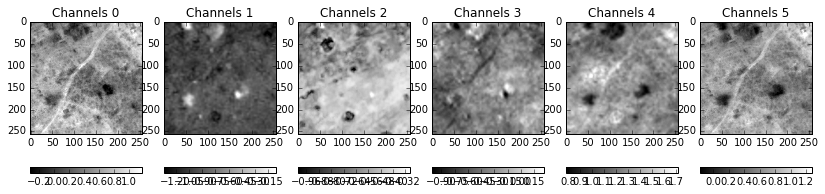

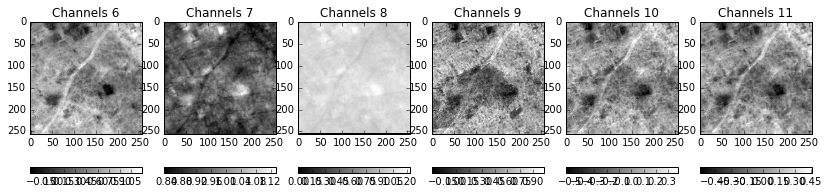

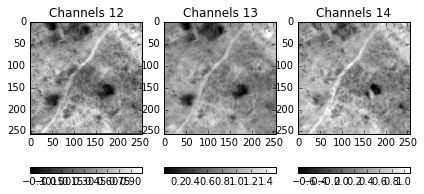

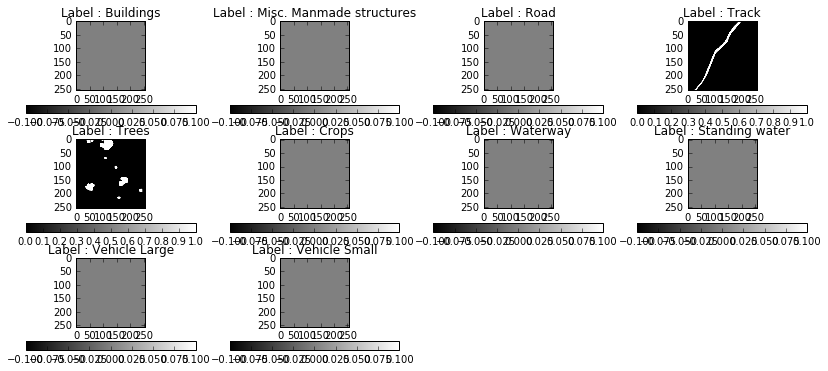

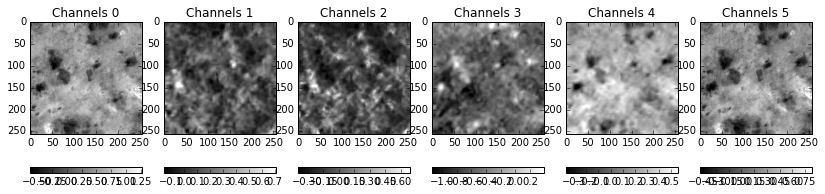

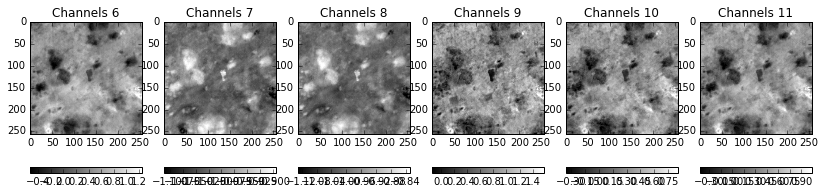

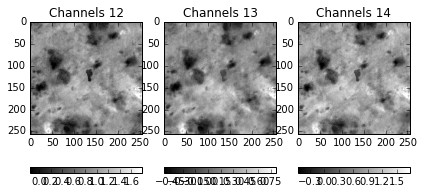

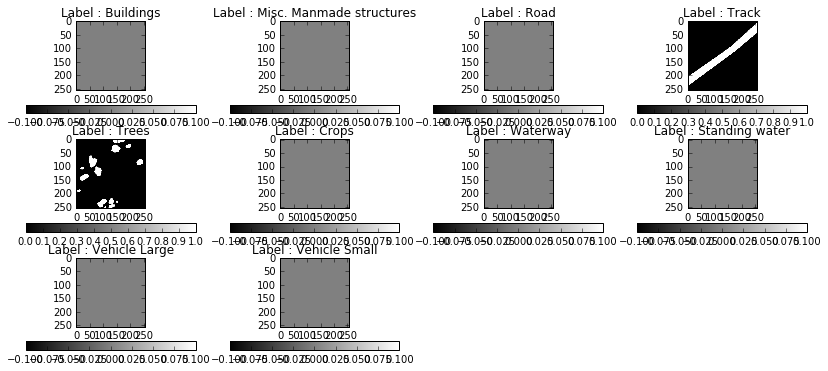

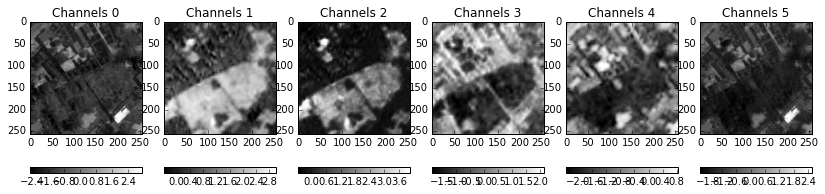

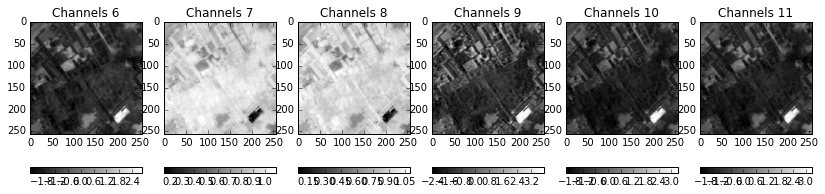

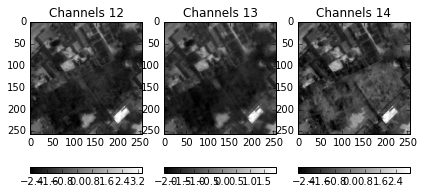

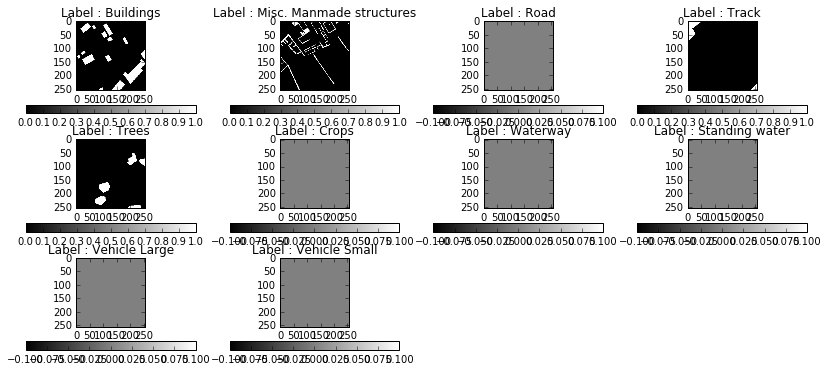

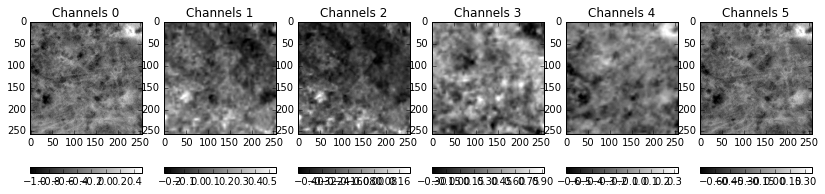

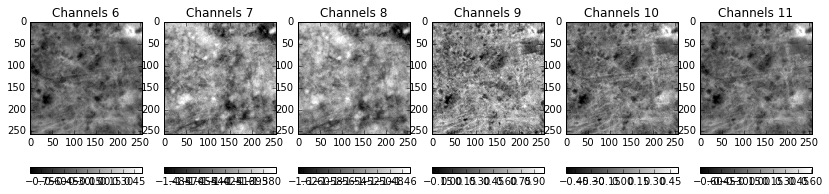

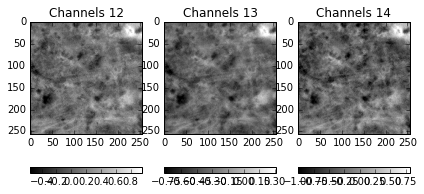

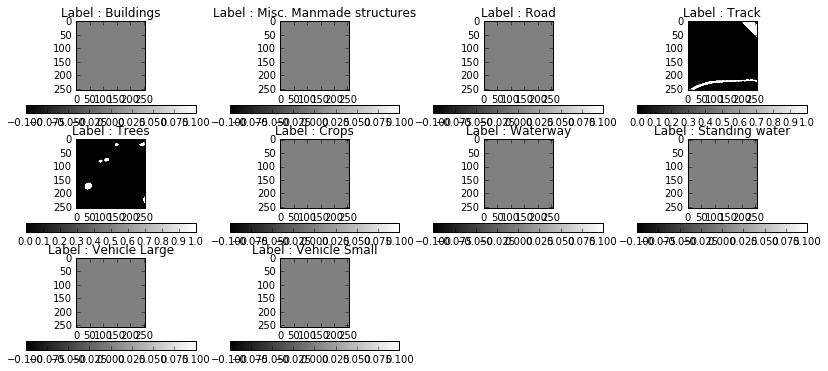

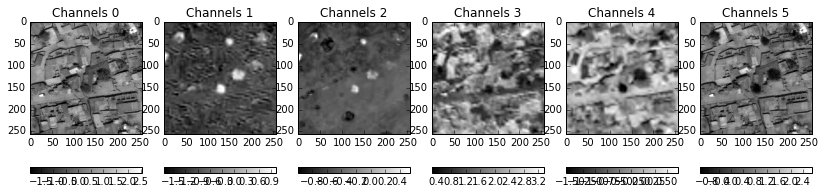

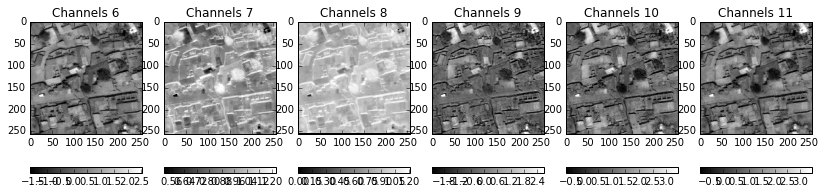

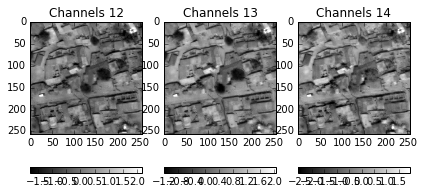

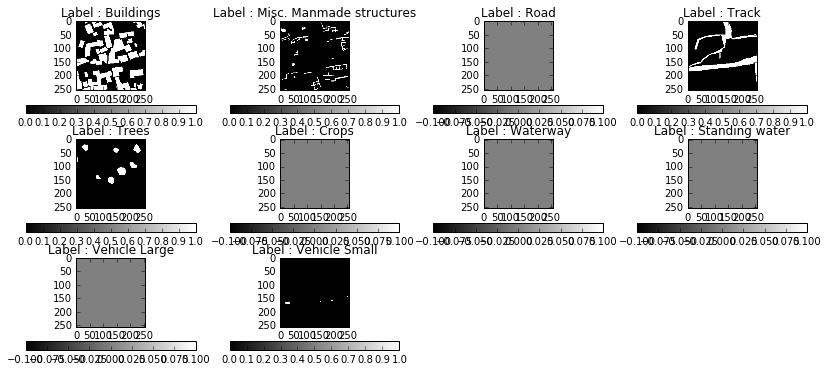

In [20]:
batch_size = 5
for X, Y in generate_images(train_files, batch_size):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    _channels = min(15, n_channels)
    for i in range(batch_size):
        
        n, m = 3, int(_channels * 1.0 / 3.0 + 1.0)
        for j in range(_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 1.0), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [22]:
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

from autoencoder import autoencoder_zero

In [31]:
n_filters_0=48
model = autoencoder_zero(n_labels, n_channels, *tile_size, n_filters_0=n_filters_0)

weights_filename = os.path.join("weights", "ae_zero_%i_%i_%i.h5" % (n_channels, n_labels, n_filters_0))
# if os.path.exists(weights_filename):
#     print "Found weights file %s" % weights_filename
#     model.load_weights(weights_filename)

In [32]:
channels, labels

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [33]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 17, 256, 256)  0                                            
____________________________________________________________________________________________________
zeropadding2d_25 (ZeroPadding2D) (None, 17, 258, 258)  0           input_4[0][0]                    
____________________________________________________________________________________________________
convolution2d_28 (Convolution2D) (None, 48, 256, 256)  7392        zeropadding2d_25[0][0]           
____________________________________________________________________________________________________
batchnormalization_25 (BatchNorm (None, 48, 256, 256)  1024        convolution2d_28[0][0]           
___________________________________________________________________________________________

In [36]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
#earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

# LearningRateScheduler

In [37]:
model.compile(optimizer=Adadelta(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])

In [38]:
# foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 4
samples_per_epoch = 4096
nb_val_samples = 512


print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_files, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=50,
    validation_data=generate_images(val_files, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint],
    verbose=2
)

4 4096 512
Epoch 1/50
8137s - loss: nan - jaccard_coef: nan - jaccard_coef_int: nan - recall: nan - precision: nan - val_loss: nan - val_jaccard_coef: nan - val_jaccard_coef_int: nan - val_recall: nan - val_precision: nan
Epoch 2/50


KeyboardInterrupt: 

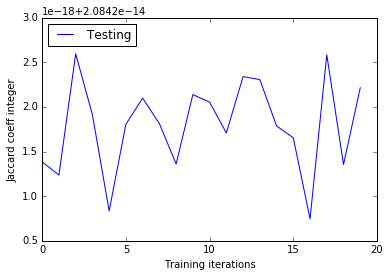

In [36]:
plt.plot(history.history['val_jaccard_coef_int'])
plt.ylabel('Jaccard coeff integer')
# plt.plot(history.history['val_jaccard_coef'])
# plt.ylabel('Jaccard coeff')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

In [37]:
def _plot(X, Y, Y_pred, i, c=1):
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    display_img_1b(X[i,0,:,:])
    plt.subplot(132)
    display_img_1b(Y[i,c,:,:])
    plt.subplot(133)
    display_img_1b(Y_pred[i,c,:,:])

(5, 3, 128, 128) 3.93127e-06 0.0013662


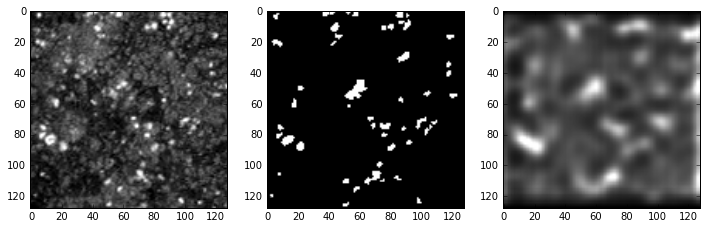

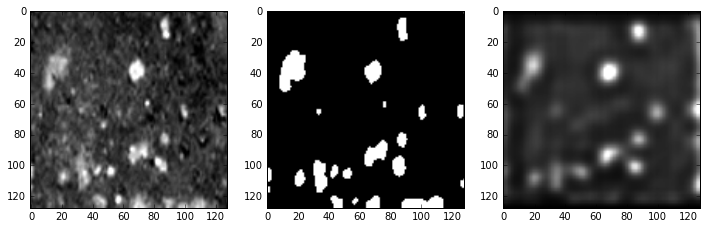

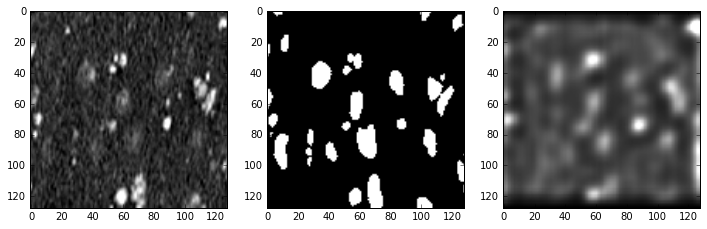

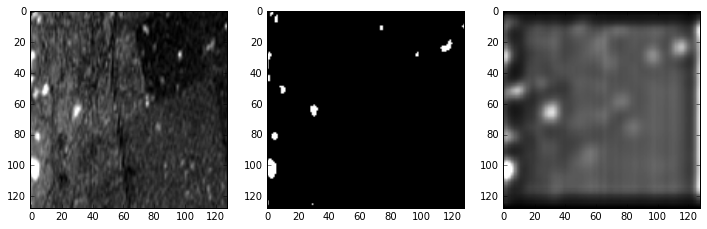

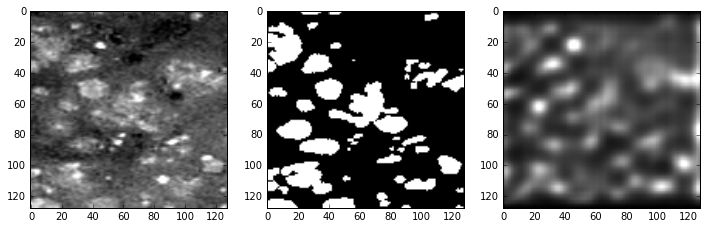

In [38]:
batch_size = 5

for X, Y in generate_images(train_files, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

#     for i in range(batch_size):
#         _plot(X, Y, Y_pred, i)
#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break


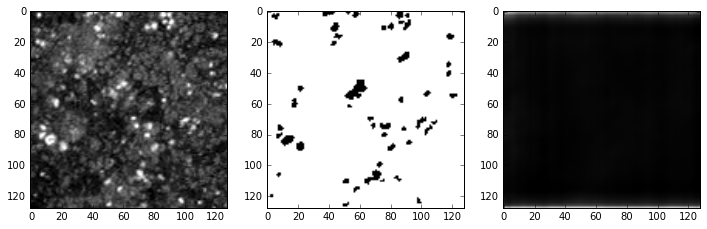

In [39]:
_plot(X, Y, Y_pred, 0, 0)

In [22]:
y = Y_pred[0,1,:,:]
print y.min(), y.max()

2.11063e-12 0.000444466
